In [159]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import json

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.api import ai_client
from src.utils import *
from src.const import *
from src.plots import *
from src.signal_providers.signal_manager import *
from src.news_providers.news_api_provider import *
from src.agents.news_filtering_agent import *
from src.agents.trading_agent import *

%load_ext autoreload
%autoreload 2

sns.set_theme(style="darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
coin = "DOGE"

cutoff = subtract_time(get_current_datetime(), days=20)
str(cutoff)

'2024-04-01 14:49:45.092904'

In [165]:
day_history = get_day_history(coin, cutoff)
week_history = get_week_history(coin, cutoff)
month_history = get_month_history(coin, cutoff)
year_history = get_year_history(coin, cutoff)

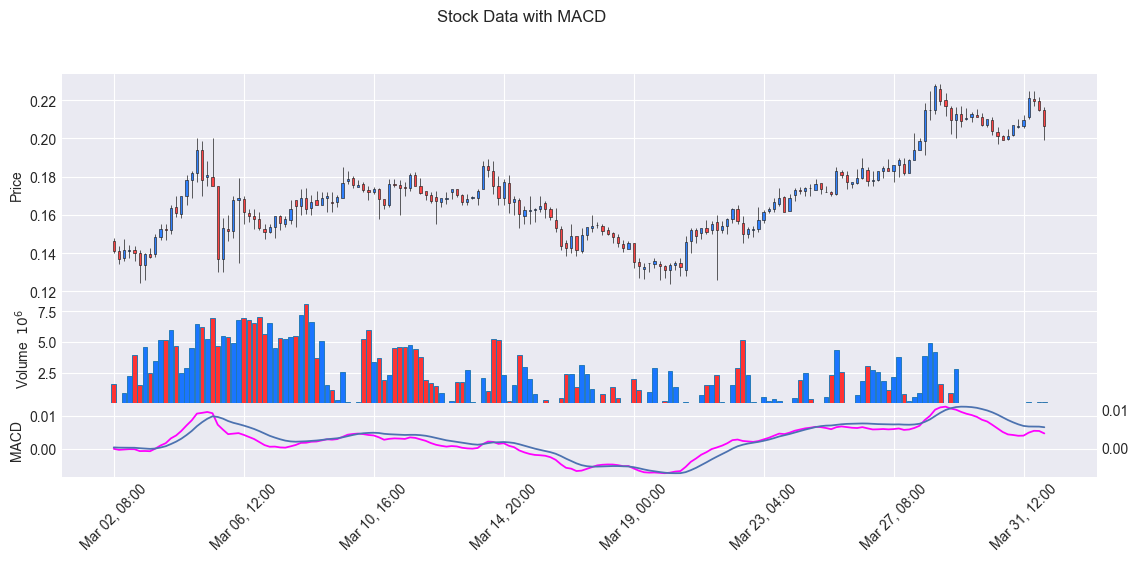

In [171]:
make_candlebars(month_history)

In [167]:
napi = NewsApi()
trading_agent = TradingAgent()
filtering_agent = NewsFilteringAgent()

In [168]:
news = napi.get_news(coin, start_date=subtract_time(cutoff, days=10), end_date=cutoff)
filtered_news = filtering_agent.filter_news(news)
json.loads(filtered_news)

{'headlines': 'Top Crypto Gainers to Watch this Week – Dogecoin, Aptos, Toncoin and New Altcoin ICOs',
 'sentiment': 'Positive',
 'description': 'The cryptocurrency market has recently shown signs of a correction, with Bitcoin and Ethereum seeing a decline. However, there is renewed investor interest in altcoins, including Toncoin, which has been highlighted as one of the top crypto gainers to watch. This signals a positive sentiment in the market as investors explore opportunities beyond the established giants, suggesting a diversifying investment landscape within the crypto market.'}

In [169]:
balance = {coin: 0, "USDT": 100}
operations_history = []

[{'role': 'system', 'content': "You are professional trader with an extensive understanding of cryptocurrency markets. \n                \n                Respond with JSON of descrived format\n                Guidelines:\n                - Do not buy on everything you have, distribute spendings!\n                - Feel free to sell all if selling improves total net_worth of acccount\n                - Consider historical market data and recent news.\n                - Use only money from your 'balance'\n                - Never close deals resulting in negative balance\n                - Never sell if you will loose money after it\n                \n                Your ultimate goal is to make 3k$\n                "}, {'role': 'user', 'content': [{'type': 'text', 'text': 'This is price history of this coin in the last day. Current price: 0.20654629'}, {'type': 'image_url', 'image_url': {'url': '', 'detail': 'high'}}]}, {'role': 'user', 'content': [{'type': 'text', 'text': 'This is pri
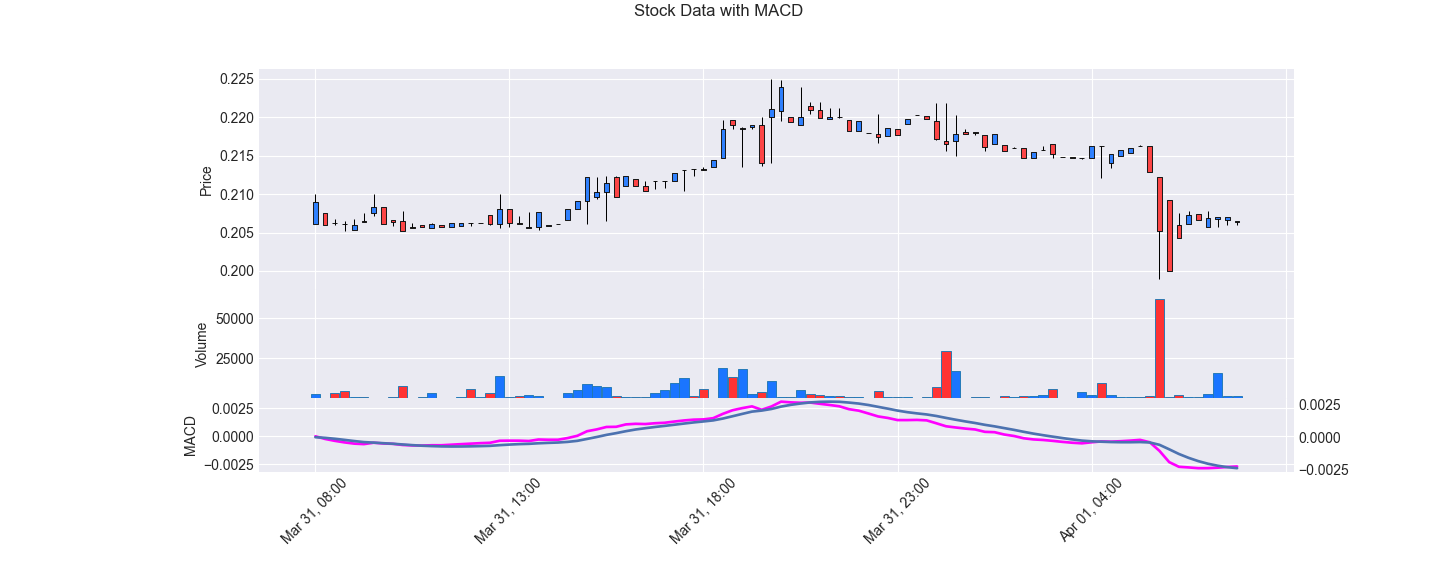
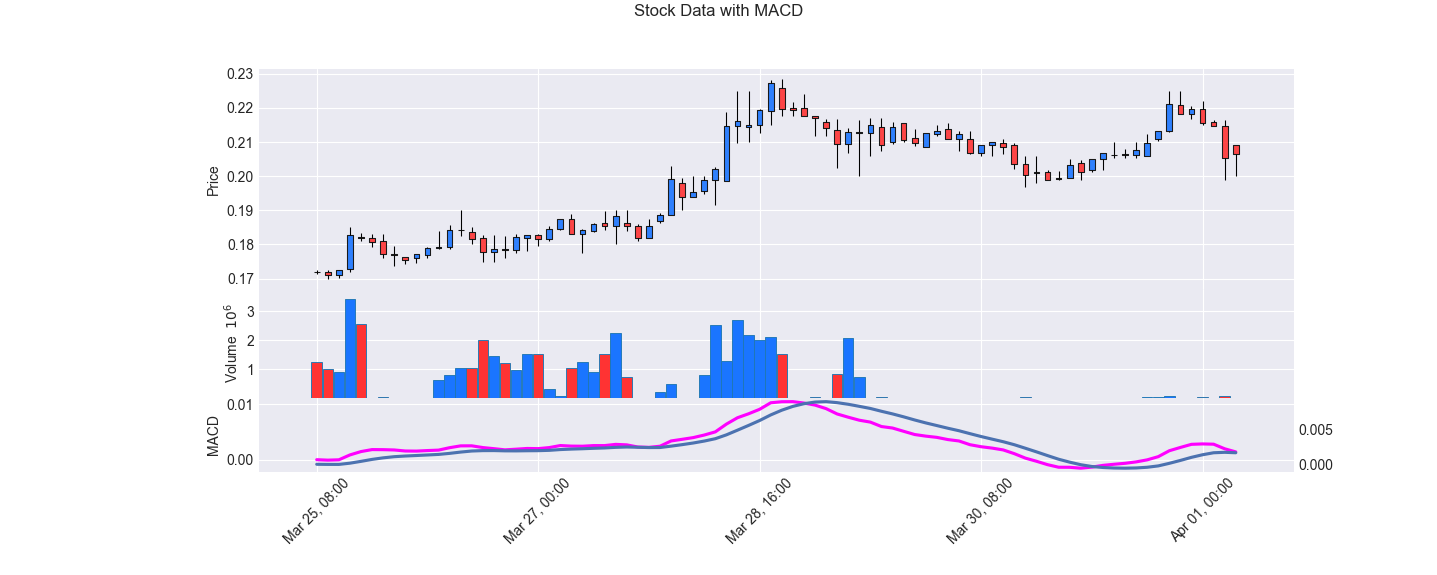
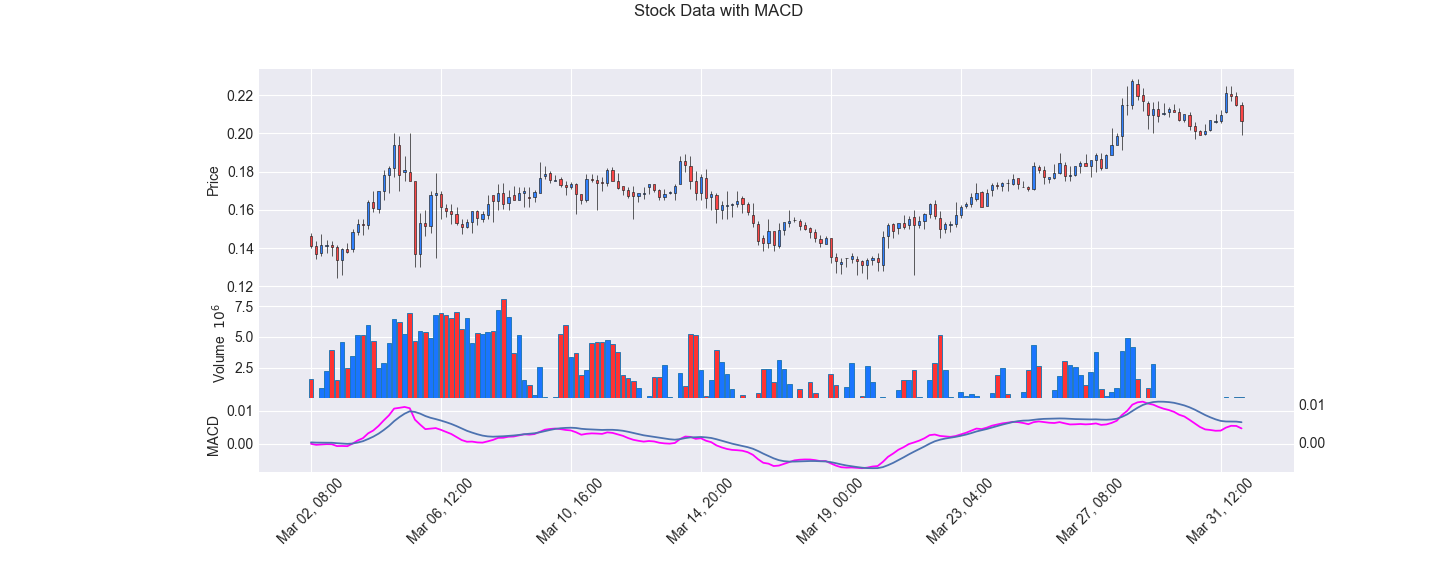

{'trend_analysis': 'Reviewing the monthly, weekly, and daily charts shows a stable rising pattern in the price of DOGE, interrupted by normal market corrections. The recent positive news headline underscores potential growth spurred by investor interest in altcoins including DOGE. The momentum appears to carry the coin to a higher valuation in the mid to long-term.',
 'technical_analysis': 'The MACD indicator on the daily and weekly charts shows a near bullish crossover, signaling potential upward movement. Prices are currently near a strong support level seen over the past week, indicating it might be a promising buy position if the price does not break below this level.',
 'price': '0.20654629',
 'profits_on_sell': 'Since there are currently 0 DOGE in the account, selling would not result in any profit or loss. Calculation shows: Profits = DOGE amount * (Current Price - Purchase Price) = 0 * (0.20654629 - Purchase Price) = 0 USD. Balance after operation: DOGE: 0, USDT: 100',
 'profit

In [172]:
predict = trading_agent.decide(
    coin=coin,
    news=filtered_news,
    day_data=day_history,
    week_data=week_history,
    month_data=month_history,
    #year_data=year_history,
    operations_history=operations_history,
    current_balance=balance,
    verbose=True,
)

result = json.loads(predict)
result

In [173]:
def update_history(balance, operations_history, result):
    if result["final_decision"] == "buy":
        balance[coin] += float(result["amount"])
        balance["USDT"] -= float(result["usdt_amount"])
        
        net_worth = balance[coin] * float(result["price"]) + balance["USDT"]
        #balance["net_worth"] = net_worth
        
        operations_history.append(
            {"action": "buy", "amount": result["amount"], "price": result["price"], "date": str(cutoff), "net_worth": net_worth}
        )

    if result["final_decision"] == "sell":
        balance[coin] -= float(result["amount"])
        balance["USDT"] += float(result["usdt_amount"])
        
        net_worth = balance[coin] * float(result["price"]) + balance["USDT"]

        #balance["net_worth"] = net_worth
        
        operations_history.append(
            {"action": "sell", "amount": result["amount"], "price": result["price"], "date": str(cutoff), "net_worth": net_worth}
        )

In [174]:
update_history(balance, operations_history, result)
print(balance, operations_history)

{'DOGE': 242.019, 'USDT': 50.0} [{'action': 'buy', 'amount': '242.019', 'price': '0.20654629', 'date': '2024-04-01 14:49:45.092904', 'net_worth': 99.98812655951}]


In [186]:
balance = {coin: 0, "USDT": 1000}
operations_history = []
cutoff = subtract_time(get_current_datetime(), days=50)

results = []
print(cutoff)

2024-03-02 15:52:54.107753


In [187]:
def run_simulation():
    print("Running at: " + str(cutoff))
    day_history = get_day_history(coin, cutoff)
    week_history = get_week_history(coin, cutoff)
    month_history = get_month_history(coin, cutoff)
    year_history = get_year_history(coin, cutoff)

    #news = napi.get_news(
    #    coin, start_date=subtract_time(cutoff, days=10), end_date=cutoff
    #)
    #filtered_news = filtering_agent.filter_news(news)

    predict = trading_agent.decide(
        coin=coin,
        news=filtered_news,
        day_data=day_history,
        week_data=week_history,
        month_data=month_history,
        #year_data=year_history,
        operations_history=operations_history,
        current_balance=balance,
        verbose=False,
    )

    result = json.loads(predict)
    results.append(result)
    
    update_history(balance, operations_history, result)
    print(balance, operations_history)

In [188]:
for x in range(50):
    print("Step " + str(x))
    run_simulation()
    cutoff = add_time(cutoff, days=1)

Step 0
Running at: 2024-03-02 15:52:54.107753
{'DOGE': 500.0, 'USDT': 926.0} [{'action': 'buy', 'amount': '500', 'price': '0.148', 'date': '2024-03-02 15:52:54.107753', 'net_worth': 1000.0}]
Step 1
Running at: 2024-03-03 15:52:54.107753
{'DOGE': 700.0, 'USDT': 899.58124} [{'action': 'buy', 'amount': '500', 'price': '0.148', 'date': '2024-03-02 15:52:54.107753', 'net_worth': 1000.0}, {'action': 'buy', 'amount': '200', 'price': '0.1320938', 'date': '2024-03-03 15:52:54.107753', 'net_worth': 992.0469}]
Step 2
Running at: 2024-03-04 15:52:54.107753
{'DOGE': 700.0, 'USDT': 899.58124} [{'action': 'buy', 'amount': '500', 'price': '0.148', 'date': '2024-03-02 15:52:54.107753', 'net_worth': 1000.0}, {'action': 'buy', 'amount': '200', 'price': '0.1320938', 'date': '2024-03-03 15:52:54.107753', 'net_worth': 992.0469}]
Step 3
Running at: 2024-03-05 15:52:54.107753
{'DOGE': 700.0, 'USDT': 899.58124} [{'action': 'buy', 'amount': '500', 'price': '0.148', 'date': '2024-03-02 15:52:54.107753', 'net_wor

In [180]:
results

[{'trend_analysis': 'Review of multi-timeframe charts indicates a potentially bullish trend for DOGE in the short-term spurred by positive sentiment from the crypto community towards altcoins, especially Dogecoin. The MACD lines are close to a bullish crossover on the daily chart. Given the recent surge in interest and positive news, it seems feasible that Dogecoin might experience short-term gains.',
  'technical_analysis': 'The MACD indicator across daily and weekly charts shows a narrowing gap between its moving lines, hinting at possible upward momentum. The recent volume spikes coincide with increasing prices which tend to signal strong buying interest and potential price continuation.',
  'price': '0.20308928',
  'profits_on_sell': 'Since you own 0 DOGE, selling is not possible. Balance after operation: DOGE: 0, USDT: 1000',
  'profits_on_buy': 'Buying DOGE now with part of your USD reserves (e.g., $250) would allow acquiring approximately 1230.46 DOGE at the current price of $0.

In [189]:
operations_history

[{'action': 'buy',
  'amount': '500',
  'price': '0.148',
  'date': '2024-03-02 15:52:54.107753',
  'net_worth': 1000.0},
 {'action': 'buy',
  'amount': '200',
  'price': '0.1320938',
  'date': '2024-03-03 15:52:54.107753',
  'net_worth': 992.0469},
 {'action': 'buy',
  'amount': '100',
  'price': '0.153258',
  'date': '2024-03-07 15:52:54.107753',
  'net_worth': 1006.85764},
 {'action': 'sell',
  'amount': '800',
  'price': '0.16372',
  'date': '2024-03-08 15:52:54.107753',
  'net_worth': 1015.2272399999999},
 {'action': 'buy',
  'amount': '100',
  'price': '0.16674',
  'date': '2024-03-09 15:52:54.107753',
  'net_worth': 1015.2272399999999},
 {'action': 'sell',
  'amount': '100',
  'price': '0.175644',
  'date': '2024-03-11 15:52:54.107753',
  'net_worth': 1016.1176399999999},
 {'action': 'buy',
  'amount': '10',
  'price': '0.16993',
  'date': '2024-03-12 15:52:54.107753',
  'net_worth': 1016.1176399999999},
 {'action': 'buy',
  'amount': '1510',
  'price': '0.13245865',
  'date': '

In [190]:
balance

{'DOGE': 1500.0, 'USDT': 631.3096450000002}

In [192]:
# Initialize balances
usd_balance = 1000.0
coin_balance = 0.0

transactions = operations_history

for tx in transactions:
    action = tx['action']
    amount = float(tx['amount'])
    price = float(tx['price'])

    if action == 'buy':
        total_cost = amount * price
        usd_balance -= total_cost
        coin_balance += amount
    elif action == 'sell':
        total_proceeds = amount * price
        usd_balance += total_proceeds
        coin_balance -= amount

    # Calculate current net worth
    current_net_worth = usd_balance + (coin_balance * price)
    print(f"Action: {action.upper()}, Amount: {amount}, Price: {price}, USD: {usd_balance:.2f}, Coins: {coin_balance:.2f}, Net Worth: {current_net_worth:.2f}")

Action: BUY, Amount: 500.0, Price: 0.148, USD: 926.00, Coins: 500.00, Net Worth: 1000.00
Action: BUY, Amount: 200.0, Price: 0.1320938, USD: 899.58, Coins: 700.00, Net Worth: 992.05
Action: BUY, Amount: 100.0, Price: 0.153258, USD: 884.26, Coins: 800.00, Net Worth: 1006.86
Action: SELL, Amount: 800.0, Price: 0.16372, USD: 1015.23, Coins: 0.00, Net Worth: 1015.23
Action: BUY, Amount: 100.0, Price: 0.16674, USD: 998.56, Coins: 100.00, Net Worth: 1015.23
Action: SELL, Amount: 100.0, Price: 0.175644, USD: 1016.12, Coins: 0.00, Net Worth: 1016.12
Action: BUY, Amount: 10.0, Price: 0.16993, USD: 1014.42, Coins: 10.00, Net Worth: 1016.12
Action: BUY, Amount: 1510.0, Price: 0.13245865, USD: 814.41, Coins: 1520.00, Net Worth: 1015.75
Action: SELL, Amount: 1520.0, Price: 0.173018, USD: 1077.40, Coins: 0.00, Net Worth: 1077.40
Action: BUY, Amount: 500.0, Price: 0.1715005, USD: 991.65, Coins: 500.00, Net Worth: 1077.40
Action: SELL, Amount: 500.0, Price: 0.181085, USD: 1082.19, Coins: 0.00, Net Wort